In [1]:
from os import listdir, mkdir
from os.path import isdir, isfile
from scipy.stats.stats import spearmanr, pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from Cluster_Evaluation_Utils import *
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

f = mtick.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))


rcParams = {'font.size': 30 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)

def Plot(df_):
    df = deepcopy(df_)
    df.loc[df['DADA2_Counts']==-1, 'DADA2_Counts']=1
    df.loc[df['SCRAPT_Counts']==-1, 'SCRAPT_Counts']=1
    
    fig, ax = plt.subplots(1,1,figsize = (18,12))
    df.plot.scatter('DADA2_Counts','SCRAPT_Counts', s = 60, ax = ax, color = 'black', alpha = 0.055)
    ax.plot([0,10000000], [0,10000000], color = 'red', linestyle = '--', linewidth = 3.0)
    ax.set_xlabel('Size of the cluster produced by DADA2')
    ax.set_ylabel('Size of the cluster produced by SCRAPT \n corresponding to the DADA2 cluster')
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.tight_layout()

    pearson_r = round(pearsonr(df['DADA2_Counts'], df['SCRAPT_Counts'])[0], 2)
    pearson_p = round(pearsonr(df['DADA2_Counts'], df['SCRAPT_Counts'])[1])

    spearman_r = round(spearmanr(df['DADA2_Counts'], df['SCRAPT_Counts'])[0], 2)
    
    if pearson_p < 0.001:
        ax.text(10000, 10, r'Pearson $\rho$: '+str(pearson_r)+',(p < 0.001)')
    return fig


In [2]:
merge_tara_oceans='/Users/harihara/Research-Activities/Data/SCRAPT/Tara_Oceans_Polar/Merged_DADA2_SCRAPT/\
SCRAPT_0.98_Alpha_0.05_DADA2_0.99_'
dada2_path = '/Users/harihara/Research-Activities/Data/SCRAPT/Tara_Oceans_Polar/\
tara_ocean_larger_dts_dada2_centroids_counts.txt'

df_dada2_tara_oceans = pd.read_csv(dada2_path, sep = ";", skiprows=1, names=['Seq', 'DADA2_Counts'], 
                                   index_col = 'Seq')
df_DADA2_tara_oceans_sum = pd.read_csv(merge_tara_oceans+'sum.txt', sep = "\t")
df_DADA2_tara_oceans_max = pd.read_csv(merge_tara_oceans+'max.txt', sep = "\t")

In [14]:
merge_spatial_soil='/Users/harihara/Research-Activities/Data/SCRAPT/Spatial_Soil/Merged_DADA2_SCRAPT/\
SCRAPT_0.97_Alpha_0.05_DADA2_0.98_'
dada2_path = '/Users/harihara/Research-Activities/Data/SCRAPT/Spatial_Soil/soil_joining'
df_dada2_spatial_soil = pd.read_csv(dada2_path, sep = ";", skiprows=1, names=['Seq', 'DADA2_Counts'], 
                                   index_col = 'Seq')
df_DADA2_spatial_soil_sum = pd.read_csv(merge_spatial_soil+'sum.txt', sep = "\t")
df_DADA2_spatial_soil_max = pd.read_csv(merge_spatial_soil+'max.txt', sep = "\t")

In [15]:
merge_lupus_microbiome='/Users/harihara/Research-Activities/Data/SCRAPT/Lupus-Microbiome-MT/\
Merged_DADA2_SCRAPT/SCRAPT_0.98_Alpha_1.0_DADA2_0.99_'
dada2_path = '/Users/harihara/Research-Activities/Data/SCRAPT/Lupus-Microbiome-Published/luo_by_sample.csv'
df_dada2_lupus = pd.read_csv(dada2_path, sep = ";", skiprows=1, names=['Seq', 'DADA2_Counts'], 
                                   index_col = 'Seq')
df_DADA2_lupus_sum = pd.read_csv(merge_lupus_microbiome+'sum.txt', sep = "\t")
df_DADA2_lupus_max = pd.read_csv(merge_lupus_microbiome+'max.txt', sep = "\t")

Plotting Tara Oceans

Percentage of sequences clustered only by SCRAPT: 0.64 %
Percentage of sequences clustered only by DADA2: 1.55 %


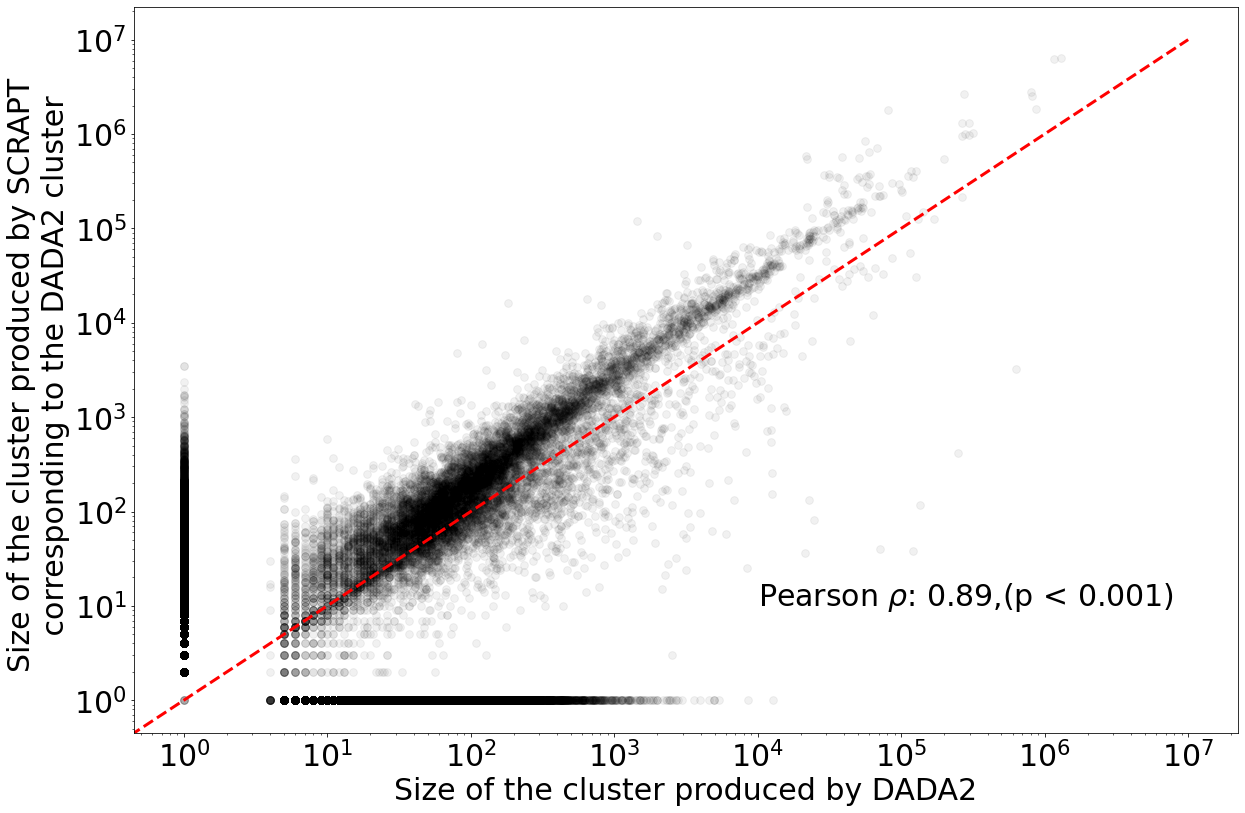

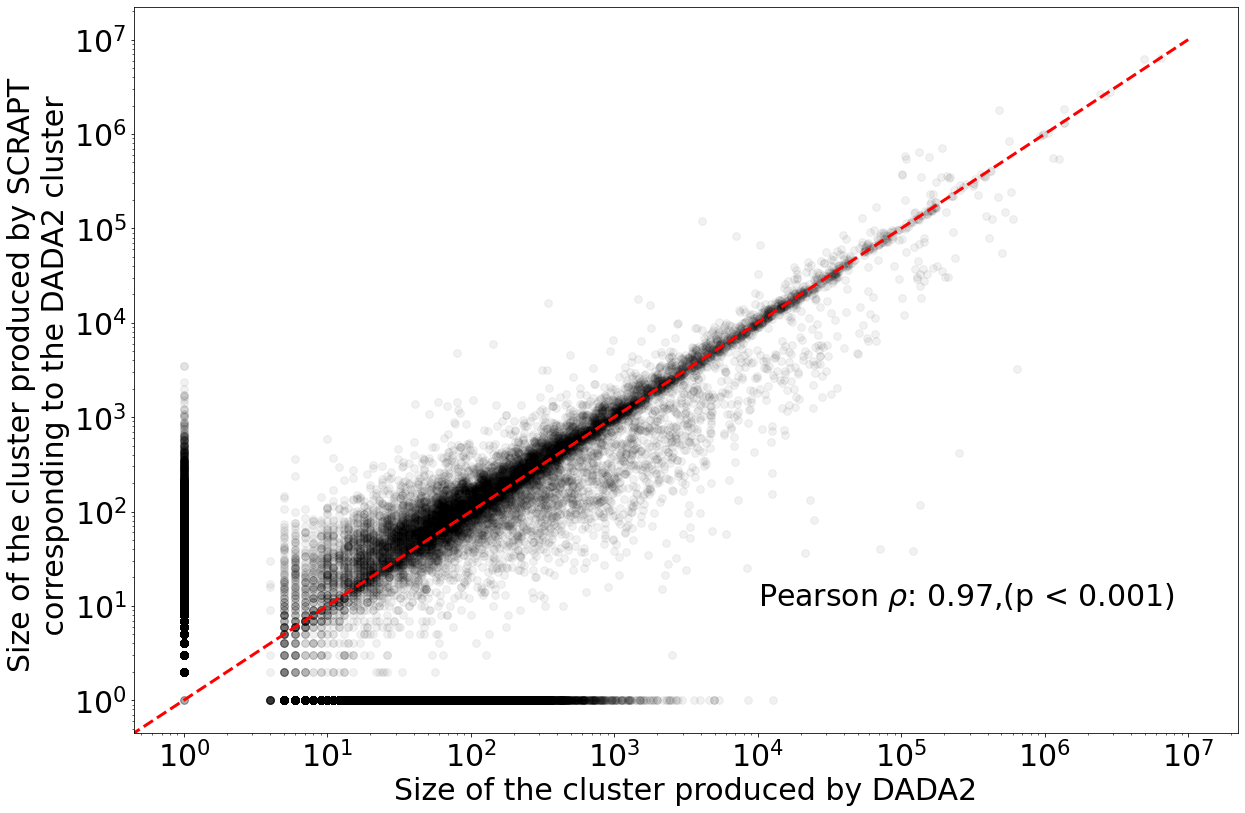

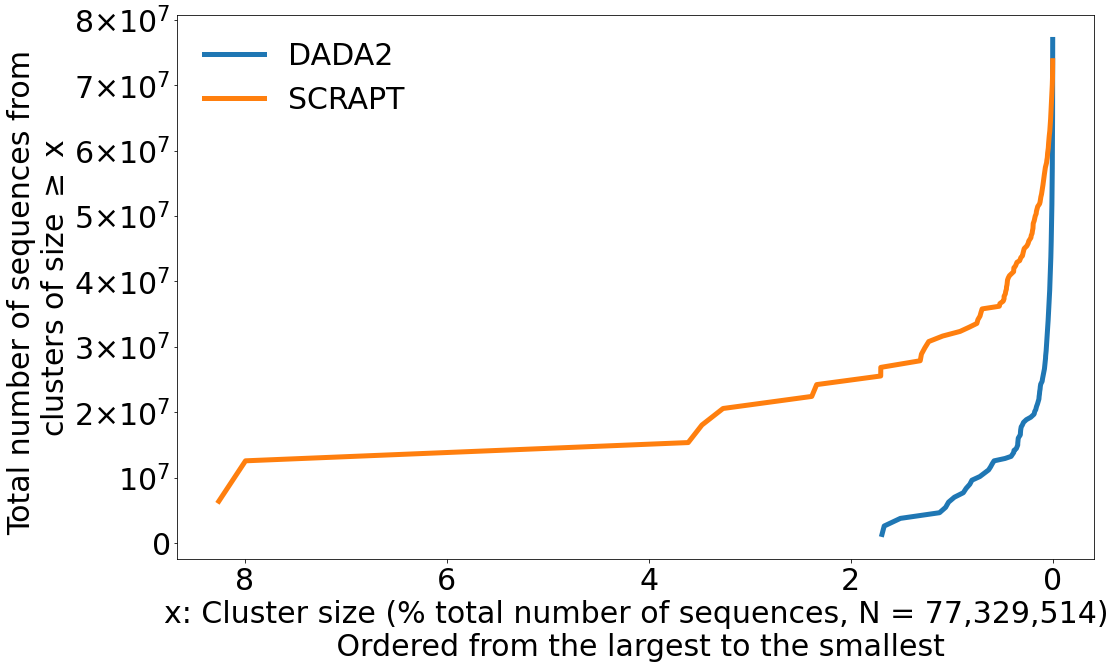

In [5]:
plt.rcParams.update(rcParams)
fig_max = Plot(df_DADA2_tara_oceans_max)
fig_sum = Plot(df_DADA2_tara_oceans_sum)

only_scrapt = df_DADA2_tara_oceans_sum[(df_DADA2_tara_oceans_max['DADA2_Counts'] == -1)]
only_dada2 = df_DADA2_tara_oceans_sum[(df_DADA2_tara_oceans_max['SCRAPT_Counts'] == -1)]
n = 77329514

print('Percentage of sequences clustered only by SCRAPT:',
      round(only_scrapt['SCRAPT_Counts'].sum()/n*100.0, 2), '%')
print('Percentage of sequences clustered only by DADA2:',
      round(only_dada2['DADA2_Counts'].sum()/n*100.0,2), '%')

plots_dir = '/Users/harihara/Research-Activities/Plots/Iterative_Clustering/Tara_Oceans_Polar/'
fig_sum.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Sum.pdf')
fig_sum.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Sum.png', dpi = 200)

fig_max.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Max.pdf')
fig_max.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Max.png', dpi = 200)

dada2_abund = df_dada2_tara_oceans['DADA2_Counts'].tolist()
cum_lupus_DADA2, NG_lupus_DADA2 = Compute_Fragmentation_Measure(dada2_abund)
scrapt_abund = df_DADA2_tara_oceans_max.loc[df_DADA2_tara_oceans_max['SCRAPT_Counts'] > 0, 'SCRAPT_Counts'].tolist()
cum_lupus_SCRAPT, NG_lupus_SCRAPT = Compute_Fragmentation_Measure(scrapt_abund)

fig,ax = plt.subplots(1,1,figsize = (16,10))
ax.plot(np.array(NG_lupus_DADA2)/n*100.0,cum_lupus_DADA2, linewidth=5, label = 'DADA2')
ax.plot(np.array(NG_lupus_SCRAPT)/n*100.0,cum_lupus_SCRAPT, linewidth=5, label = 'SCRAPT')

ax.set_xlim(ax.get_xlim()[::-1])
ylim = ax.get_ylim()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(g))
ax.legend(loc=2, frameon = False)
ax.set_ylabel('Total number of sequences from \n'+r'clusters of size $\geq$ x')
ax.set_xlabel('x: Cluster size (% total number of sequences, N = 77,329,514'+
              ')\n Ordered from the largest to the smallest')
fig.tight_layout()
fig.savefig(plots_dir+'DADA2_SCRAPT_Fragmentation_Metric.pdf')


Percentage of sequences clustered only by SCRAPT: 5.47 %
Percentage of sequences clustered only by DADA2: 11.47 %


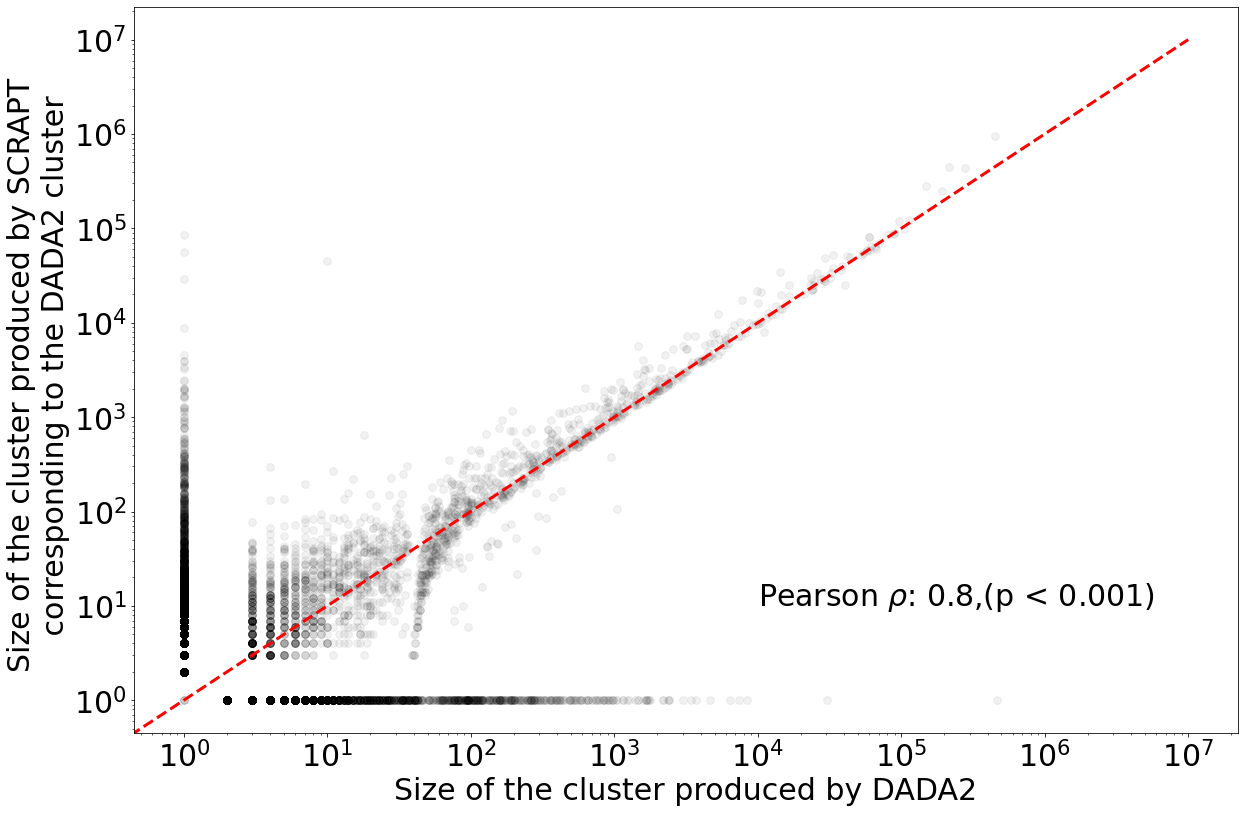

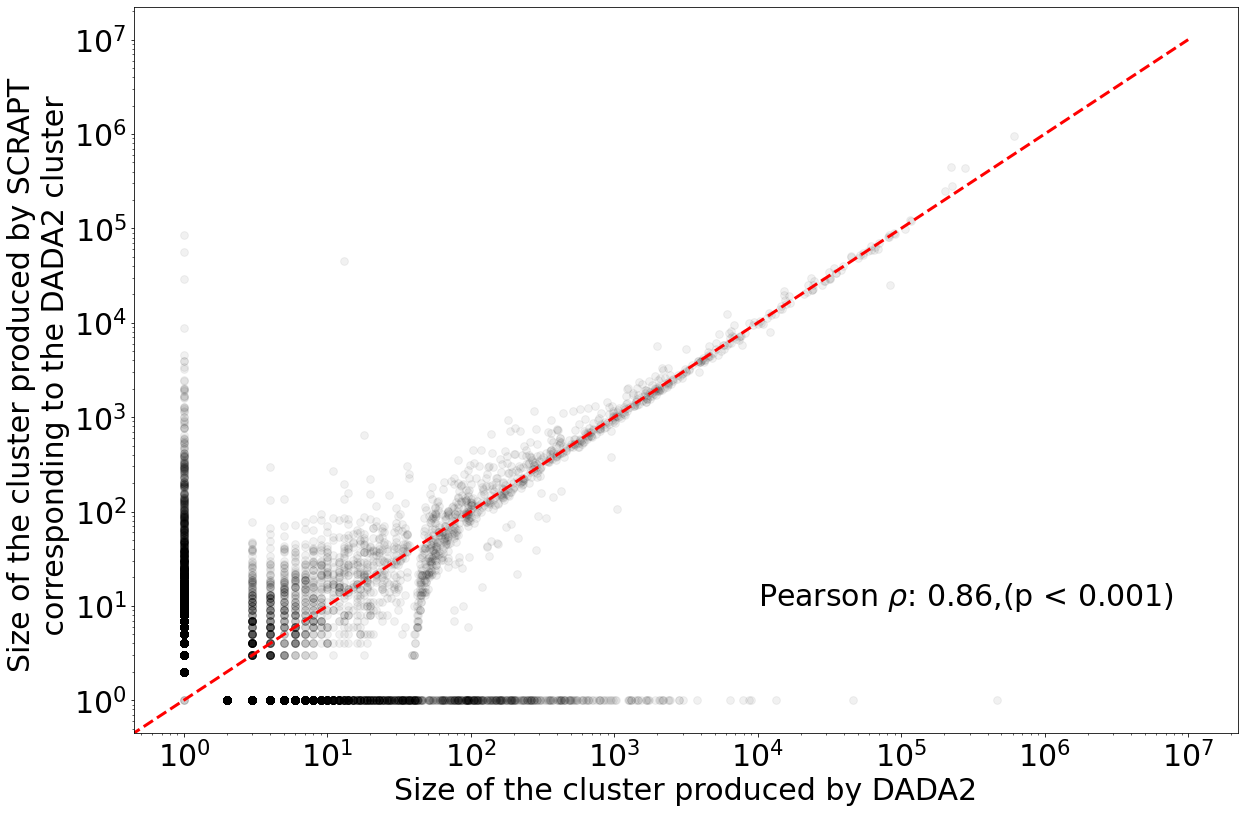

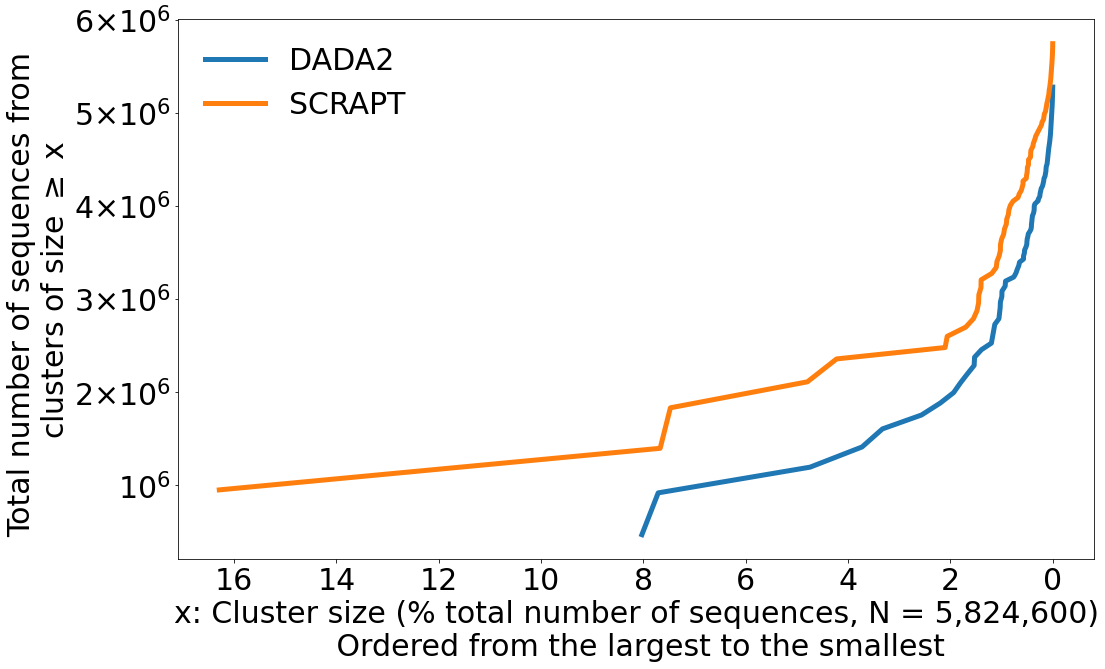

In [18]:
fig_max = Plot(df_DADA2_lupus_max)
fig_sum = Plot(df_DADA2_lupus_sum)

only_scrapt = df_DADA2_lupus_max[(df_DADA2_lupus_max['DADA2_Counts'] == -1)]
only_dada2 = df_DADA2_lupus_max[(df_DADA2_lupus_max['SCRAPT_Counts'] == -1)]

dada2_abund = df_dada2_lupus['DADA2_Counts'].tolist()
cum_lupus_DADA2, NG_lupus_DADA2 = Compute_Fragmentation_Measure(dada2_abund)
scrapt_abund = df_DADA2_lupus_max.loc[df_DADA2_lupus_max['SCRAPT_Counts'] > 0, 'SCRAPT_Counts'].tolist()
cum_lupus_SCRAPT, NG_lupus_SCRAPT = Compute_Fragmentation_Measure(scrapt_abund)

n = 5824600

print('Percentage of sequences clustered only by SCRAPT:',
      round(only_scrapt['SCRAPT_Counts'].sum()/n*100.0, 2), '%')
print('Percentage of sequences clustered only by DADA2:',
      round(only_dada2['DADA2_Counts'][0:].sum()/n*100.0,2), '%')

plots_dir = '/Users/harihara/Research-Activities/Plots/Iterative_Clustering/Lupus-Microbiome-MT/'
fig_sum.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Sum.pdf')
fig_sum.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Sum.png', dpi = 200)

fig_max.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Max.pdf')
fig_max.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.98_Max.png', dpi = 200)

fig,ax = plt.subplots(1,1,figsize = (16,10))
ax.plot(np.array(NG_lupus_DADA2)/n*100.0,cum_lupus_DADA2, linewidth=5, label = 'DADA2')
ax.plot(np.array(NG_lupus_SCRAPT)/n*100.0,cum_lupus_SCRAPT, linewidth=5, label = 'SCRAPT')

ax.set_xlim(ax.get_xlim()[::-1])
ylim = ax.get_ylim()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(g))
ax.legend(loc=2, frameon = False)
ax.set_ylabel('Total number of sequences from \n'+r'clusters of size $\geq$ x')
ax.set_xlabel('x: Cluster size (% total number of sequences, N = 5,824,600'+
              ')\n Ordered from the largest to the smallest')
fig.tight_layout()

fig.savefig(plots_dir+'DADA2_SCRAPT_Fragmentation_Metric.pdf')


Percentage of sequences clustered only by SCRAPT: 8.96 %
Percentage of sequences clustered only by DADA2: 0.05 %


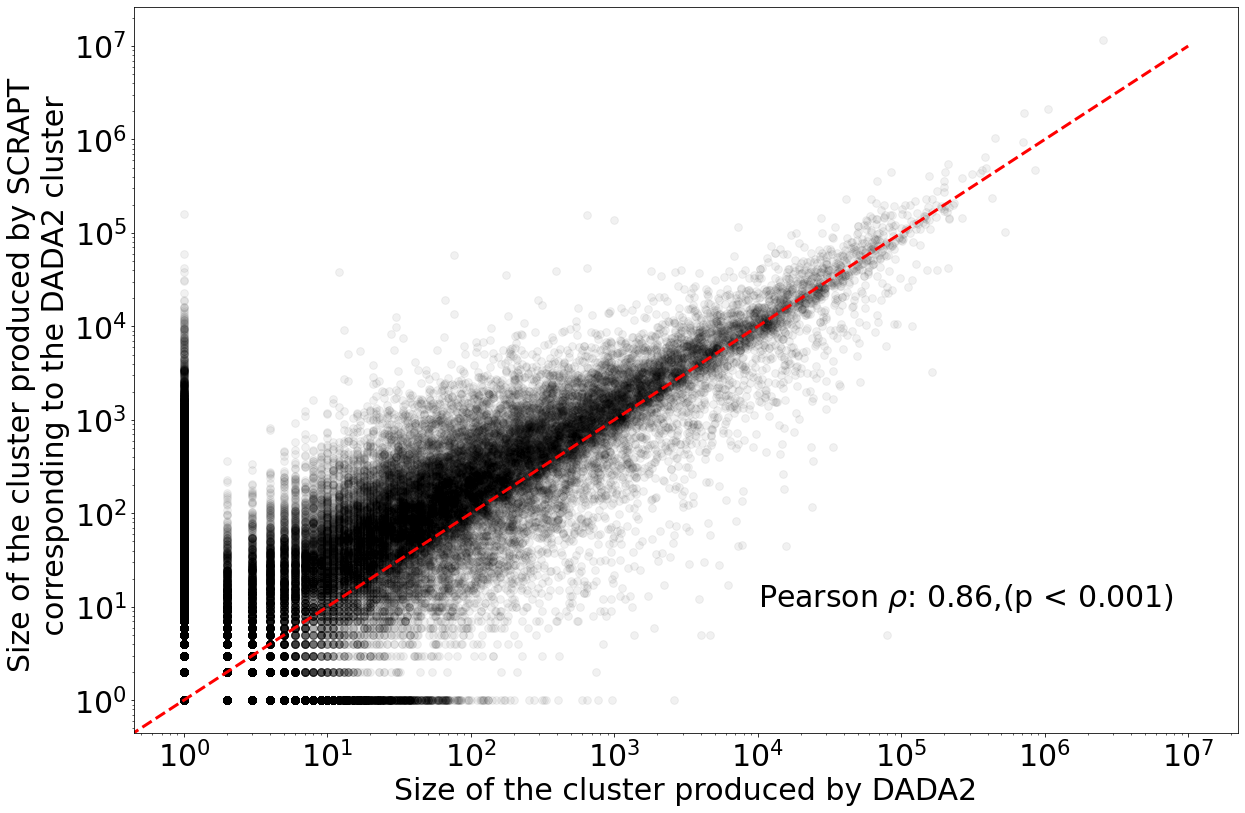

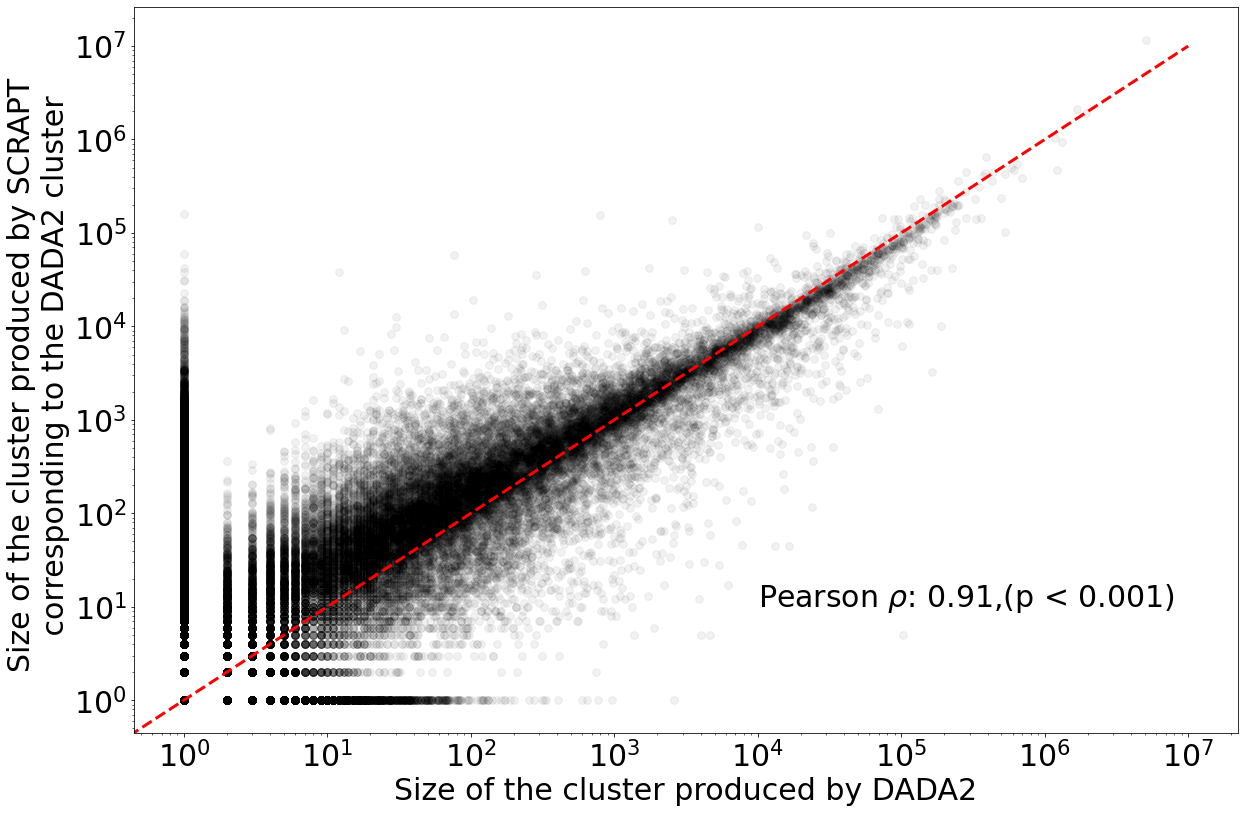

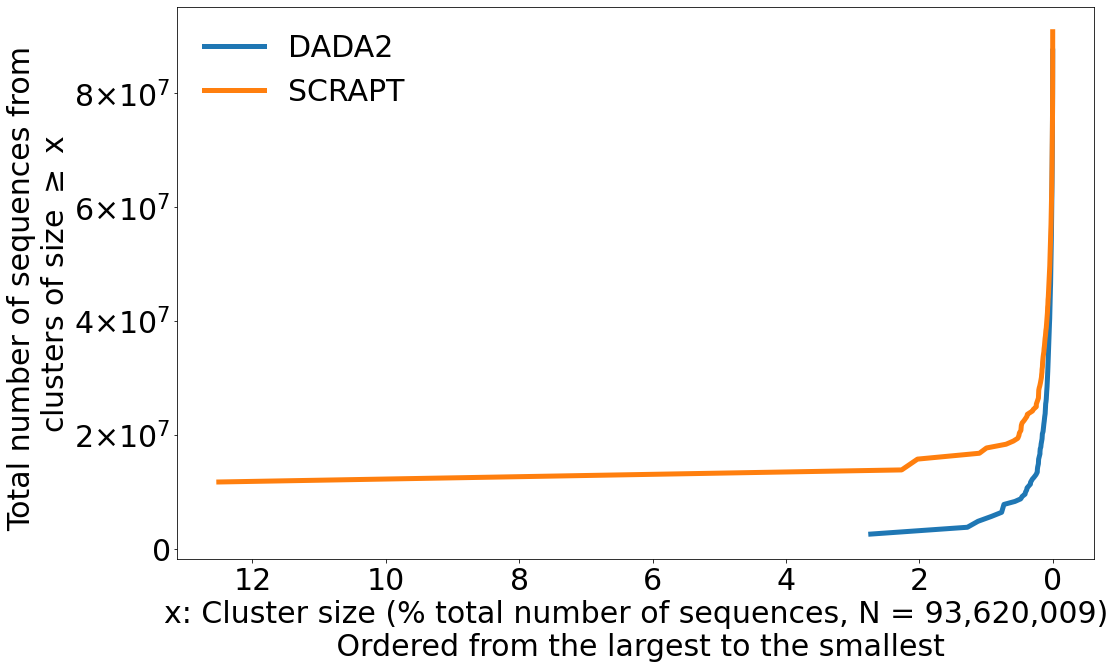

In [17]:
fig_max = Plot(df_DADA2_spatial_soil_max)
fig_sum = Plot(df_DADA2_spatial_soil_sum)

only_scrapt = df_DADA2_spatial_soil_max[(df_DADA2_spatial_soil_max['DADA2_Counts'] == -1)]
only_dada2 = df_DADA2_spatial_soil_max[(df_DADA2_spatial_soil_max['SCRAPT_Counts'] == -1)]

n = 93620009

print('Percentage of sequences clustered only by SCRAPT:',
      round(only_scrapt['SCRAPT_Counts'].sum()/n*100.0, 2), '%')
print('Percentage of sequences clustered only by DADA2:',
      round(only_dada2['DADA2_Counts'].sum()/n*100.0,2), '%')

plots_dir = '/Users/harihara/Research-Activities/Plots/Iterative_Clustering/Spatial_Soil/'
fig_sum.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.97_Sum.pdf')
fig_sum.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.97_Sum.png', dpi = 200)

fig_max.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.97_Max.pdf')
fig_max.savefig(plots_dir+'Comparing_DADA2_SCRAPT_0.97_Max.png', dpi = 200)

dada2_abund = df_dada2_spatial_soil['DADA2_Counts'].tolist()
cum_lupus_DADA2, NG_lupus_DADA2 = Compute_Fragmentation_Measure(dada2_abund)
scrapt_abund = df_DADA2_spatial_soil_max.loc[df_DADA2_spatial_soil_max['SCRAPT_Counts'] > 0, 'SCRAPT_Counts'].tolist()
cum_lupus_SCRAPT, NG_lupus_SCRAPT = Compute_Fragmentation_Measure(scrapt_abund)

fig,ax = plt.subplots(1,1,figsize = (16,10))
ax.plot(np.array(NG_lupus_DADA2)/n*100.0,cum_lupus_DADA2, linewidth=5, label = 'DADA2')
ax.plot(np.array(NG_lupus_SCRAPT)/n*100.0,cum_lupus_SCRAPT, linewidth=5, label = 'SCRAPT')

ax.set_xlim(ax.get_xlim()[::-1])
ylim = ax.get_ylim()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(g))
ax.legend(loc=2, frameon = False)
ax.set_ylabel('Total number of sequences from \n'+r'clusters of size $\geq$ x')
ax.set_xlabel('x: Cluster size (% total number of sequences, N = 93,620,009'+
              ')\n Ordered from the largest to the smallest')
fig.tight_layout()
fig.savefig(plots_dir+'DADA2_SCRAPT_Fragmentation_Metric.pdf')
